## The objectives are as follows:


- Respond to Business Requirement 2:

    - There is a client who wants to know whether a given image of a cherry leaf is healthy or if it has powdery mildew.



## Inputs


    Following sets:

* Train

* Validation

* Test



## Outputs


- Images distribution plot in train, validation, and test set.

- Increasing data diversity by enhancing images.

- Adjusting label predictions during inference by modifying class indices.

- Machine learning model creation and training.

- The trained model should be preserved (saved).

- The learning curve is plotted to visualize the performance of the model.

- Evaluating the model's performance.

- Making predictions on a randomly selected image file.

In [1]:
import os
current_dir = os.getcwd()
current_dir



'/workspaces/project5/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
work_dir = os.getcwd()
work_dir

'/workspaces/project5'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.models import load_model

from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping



In [5]:
my_data_dir = 'inputs/datasets/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'
my_data_dir

version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('There is a version is already available, please create a new version.')
  pass
else:
  os.makedirs(name=file_path)


There is a version is already available, please create a new version.


In [6]:
labels = os.listdir(train_path)

print(f"The project labels are: {labels}")

version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/images_shapes.pkl")
image_shape

The project labels are: ['powdery_mildew', 'healthy']


(64, 64, 3)

### Retrieve the counts of images in the train, validation, and test datasets, and generate a plot displaying the distribution of images across these datasets.

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images


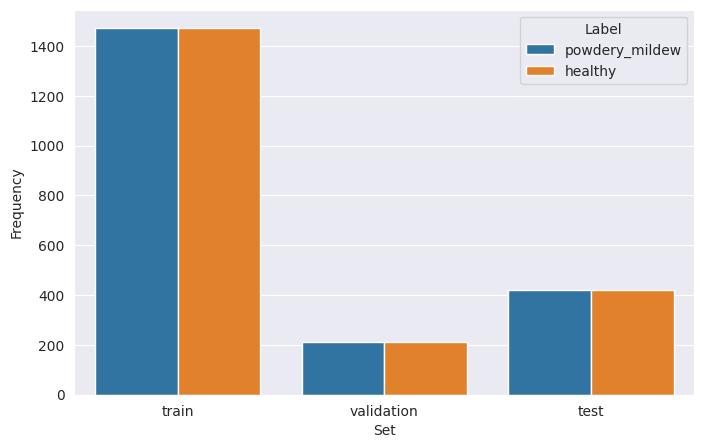

In [7]:
image_counts = []
for folder in ['train', 'validation', 'test']:
    counts = [len(os.listdir(f"{my_data_dir}/{folder}/{label}")) for label in labels]
    image_counts.extend(zip([folder]*len(labels), labels, counts))
    print('\n'.join([f"* {folder} - {label}: {count} images" for label, count in zip(labels, counts)]))

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=pd.DataFrame(image_counts, columns=['Set', 'Label', 'Frequency']), x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


### Enhancing the training process, by utilizing the ImageDataGenerator library to employ image data augmentation techniques. This will create a varied set of temporary images within the training dataset, thereby enhancing the training process

In [8]:

image_augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

training_batch_size = 20



### Visualize Augmented Training Images##

In [9]:


augmented_train_set = image_augmentor.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=True
)

augmented_train_set.class_indices


augmented_validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=training_batch_size,
    class_mode='binary',
    shuffle=False
)

augmented_validation_set.class_indices



augmented_test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=training_batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

augmented_test_set.class_indices





Found 2944 images belonging to 2 classes.
Found 844 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


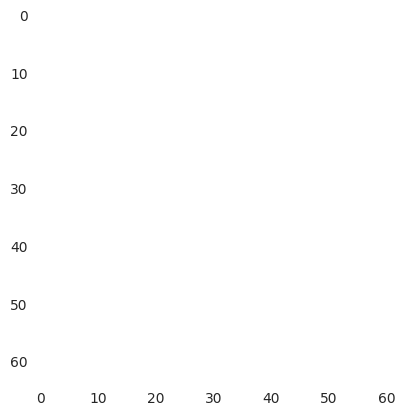

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


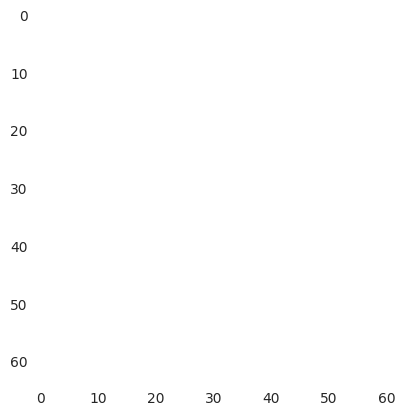

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


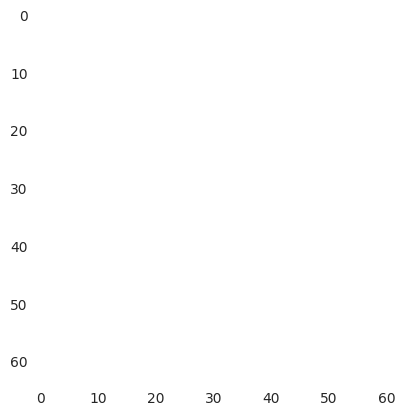

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


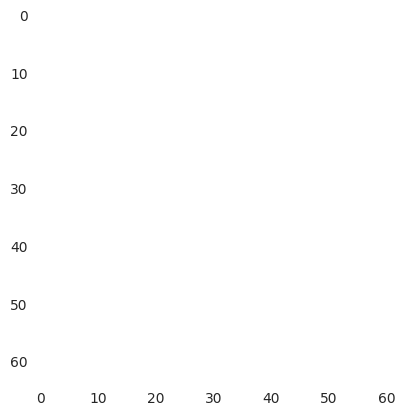

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


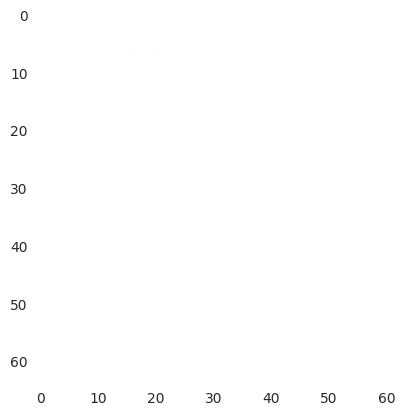

In [10]:
for _ in range(5):
    img, label = augmented_train_set.next()
    plt.imshow(img[0])
    plt.show()

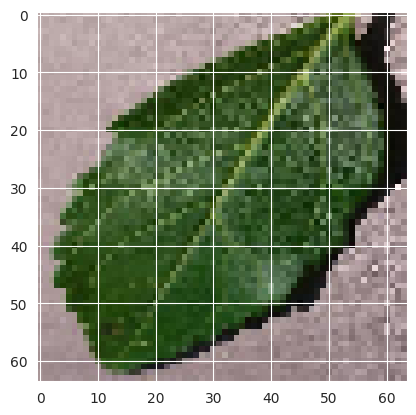

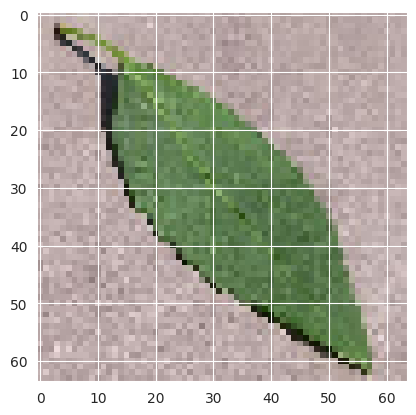

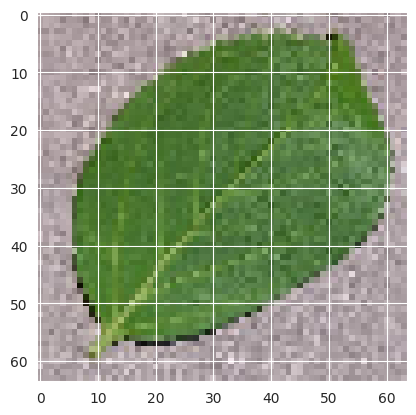

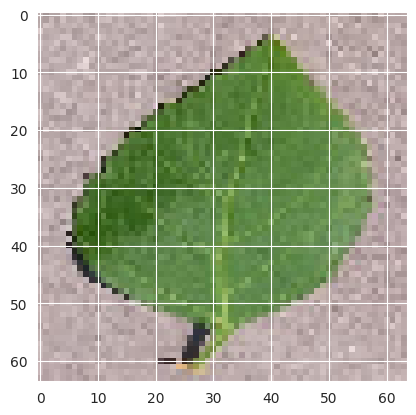

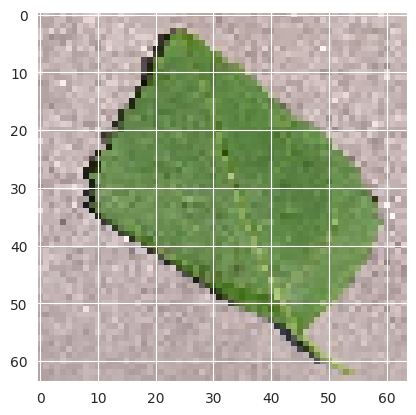

In [11]:

for _ in range(5):
    img, label = augmented_validation_set.next()
    plt.imshow(img[0])
    plt.show()

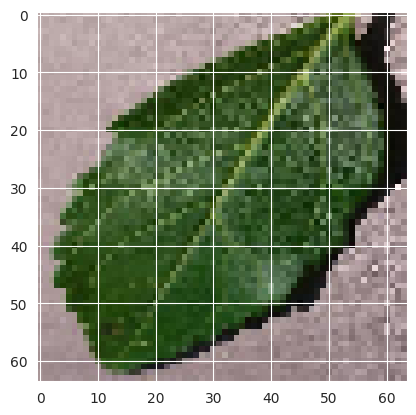

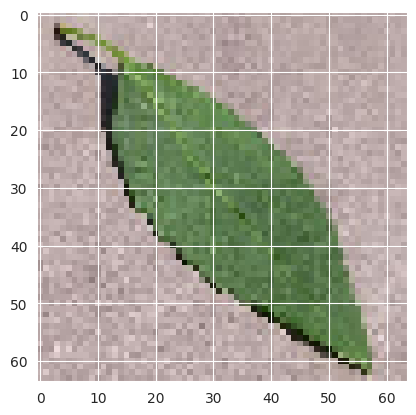

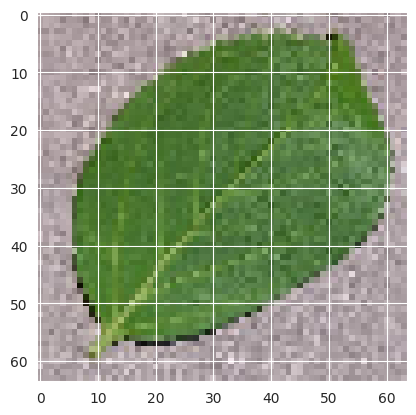

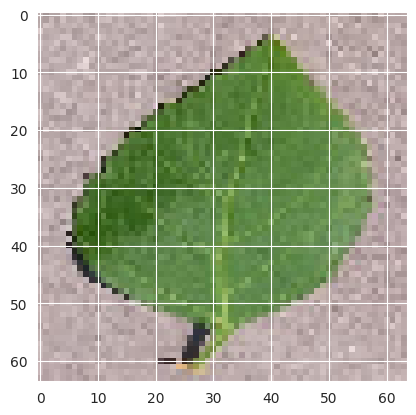

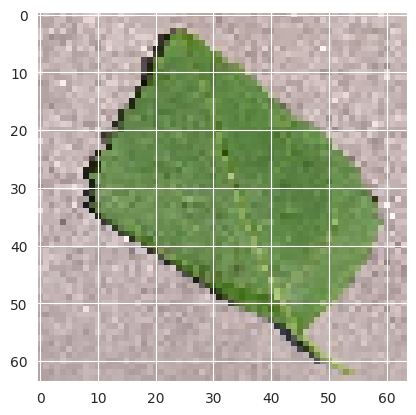

In [12]:
for _ in range(5):
    img, label = augmented_test_set.next()
    plt.imshow(img[0])
    plt.show()

In [13]:
joblib.dump(value=augmented_train_set.class_indices,
            filename=f"{file_path}/train_classes_indices.pkl")

['outputs/v1/train_classes_indices.pkl']

# Creating the model section:

#### - Creating an image classification model using convolutional, pooling, dense, and dropout layers, compiles it, and returns the model. Summary() method is then called to display the model architecture summary.

In [14]:
def create_image_classification_model():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
create_image_classification_model().summary()


2023-05-19 12:55:05.085611: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
____________________________________________

- Training an image classification model using 'augmented_train_set' dataset and validating it using the 'augmented_validation_set' dataset. EarlyStopping callback to stop training if the validation accuracy does not improve for _5_ consecutive epochs.

In [15]:
validation_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
model = create_image_classification_model()

model.fit(augmented_train_set,
          epochs=15,
          validation_data=augmented_validation_set,
          callbacks=[validation_stop],
          verbose=1)
model.save('outputs/v1/cherry_disease_model.h5')
print(f"Model saved as {model}")


2023-05-19 12:55:23.579000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/15
148/148 [==============================] - 150s 718ms/step - loss: 1.3757 - accuracy: 0.8077 - val_loss: 0.6833 - val_accuracy: 0.5000
Epoch 2/15
148/148 [==============================] - 15s 104ms/step - loss: 0.2033 - accuracy: 0.9266 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 3/15
148/148 [==============================] - 16s 106ms/step - loss: 0.2184 - accuracy: 0.9154 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 4/15
148/148 [==============================] - 15s 103ms/step - loss: 0.1649 - accuracy: 0.9392 - val_loss: 0.6865 - val_accuracy: 0.5000
Epoch 5/15
148/148 [==============================] - 15s 104ms/step - loss: 0.1062 - accuracy: 0.9637 - val_loss: 0.6888 - val_accuracy: 0.5000
Epoch 6/15
148/148 [==============================] - 16s 107ms/step - loss: 0.0923 - accuracy: 0.9711 - val_loss: 0.6

# Checking the performance of the created model

- Generating two plots: one for the loss values and one for the accuracy values from the model training history. Print plots as images.

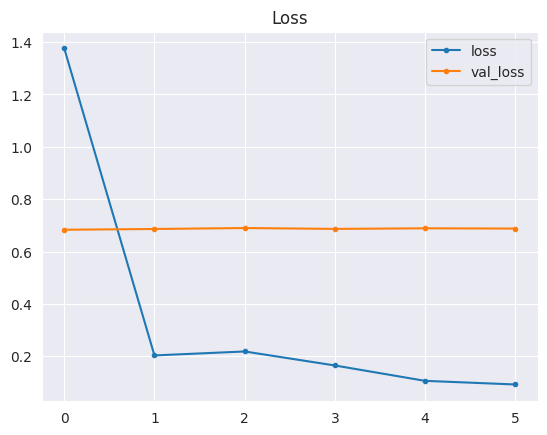

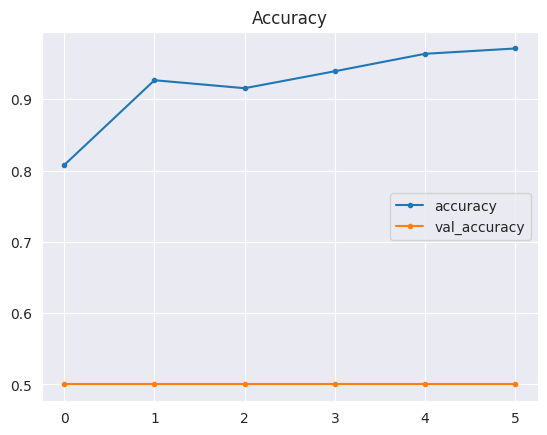

In [16]:
losses = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

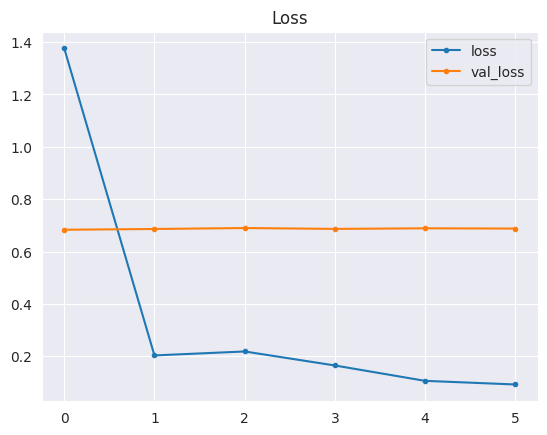

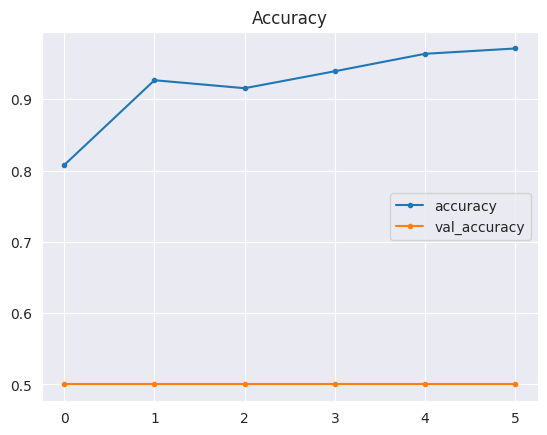

In [17]:
history_data = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
history_data[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

history_data[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_accuracy.png', bbox_inches='tight', dpi=150)
plt.show()


# Evaluating the created Model 

- 


In [18]:
evaluation = model.evaluate(augmented_test_set)
joblib.dump(value=evaluation,
            filename=f"outputs/v1/trainings/train-8/evaluation.pkl")


43/43 [==============================] - 1s 31ms/step - loss: 0.6878 - accuracy: 0.5000


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/v1/trainings/train-8/evaluation.pkl'

 # Prediction on new data

In [19]:
# from tensorflow.keras.preprocessing import image

# pointer = 66
# label = labels[1]  # select a powderly mildew infected image

# pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
#                            target_size=image_shape, color_mode='rgb')
# print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
# pil_image

# Summary

### To Fix:
- play around with Patience (L53)and epoch (l53)
- Val_loss and val_accuracy don't seem to be good - There is high loss (0.7) and and low accuracy (0.5)